# 06 Region classifier

**Objectives:**
* train a classifier to predict Regions (`-->` multiclass)
* explain classifications in different regions with LIME

In [166]:
import pandas as pd
import numpy as np
import os
import pickle
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix

import lime 
import sklearn.datasets
from lime.lime_tabular import LimeTabularExplainer

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

sns.set(style="whitegrid")

---

## Load the data

In [2]:
wd = '/media/tmo/data/work/datasets/02_ST'

logcpm_path = wd + '/ashley_21.03.2018/logcpm_merge_20180212.pickle'
meta_path = wd + '/meta/meta.parquet'

In [3]:
%%time
meta_df = pd.read_parquet(meta_path)

CPU times: user 122 ms, sys: 274 ms, total: 396 ms
Wall time: 193 ms


In [4]:
%%time
logcpm_df = pickle.load(open(logcpm_path, "rb"))

logcpm_df.index.name = 'spot_UID'
logcpm_df.reset_index(inplace=True)
logcpm_df.rename(columns={'sampleID': 'slide_ID'}, inplace=True)

CPU times: user 16 s, sys: 6.89 s, total: 22.9 s
Wall time: 22.9 s


In [5]:
st_df = logcpm_df.merge(meta_df, how='inner', on=['spot_UID', 'slide_ID'])

In [6]:
st_df['slide_ID'] = st_df['slide_ID'].astype('category', copy=False)
st_df['GT'] = st_df['GT'].astype('category', copy=False)
st_df['age'] = st_df['age_GT'].astype('category', copy=False)
st_df['age_GT'] = st_df['age_GT'].astype('category', copy=False)

In [7]:
n_genes = 46454
gene_columns = st_df.columns[1:n_genes+1]

In [8]:
expression_df = st_df[gene_columns]

In [9]:
assert expression_df.shape == (10327, 46454)

In [108]:
region_levels_df = pd.read_csv('region_levels.csv', sep=',', keep_default_na=False)

In [110]:
genotype_df = st_df[['GT']]

In [111]:
region_df = st_df[['Region_predict']].copy()

In [112]:
region_df = region_df.merge(region_levels_df, on='Region_predict')

In [113]:
region_cat_df = region_df['Region_predict'].astype('category', copy=False)
region_level1_df = region_df['Level_01'].astype('category', copy=False)
region_level2_df = region_df['Level_02'].astype('category', copy=False)

---



In [120]:
region_df['Level_01'].value_counts()

CX    4104
BS    3028
NA    1651
HP    1544
Name: Level_01, dtype: int64

In [119]:
region_df['Level_02'].value_counts()

TH       1931
FB       1155
HPd      1122
HY       1097
AUD       860
OLF       749
CTXsp     709
PTL       585
SSp       532
NA        496
HPs       422
COM       295
RSP       262
ENTI      112
Name: Level_02, dtype: int64

---
## Extract *all-relevant* feature set: Region

In [25]:
boruta_rf = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_features='sqrt', max_depth=5)

def train_feature_selector(X_df=expression_df,  # the transcriptome expression vectors
                           y_df=region_df,      # the Region column
                           estimator=boruta_rf, verbose=2, seed=42):  # boruta parameters
    feature_selector = BorutaPy(estimator=estimator, verbose=verbose, random_state=seed, n_estimators='auto')    
    
    X = X_df.as_matrix()
    y = y_df.values.ravel()
    feature_selector.fit(X, y)
    
    return feature_selector

In [ ]:
Region_feature_selector = train_feature_selector(y_df = region_df)

In [27]:
Region_features = list(gene_columns[Region_feature_selector.support_])

In [30]:
pd.DataFrame(Region_features).to_csv('06_region_features.txt', index=None, header=None)

## Extract *all-relevant* feature set: Level 01

In [ ]:
# level1_feature_selector = train_feature_selector(y_df = region_level1_df)

In [124]:
# Level1_features = list(gene_columns[level1_feature_selector.support_])

In [126]:
# pd.DataFrame(Level1_features).to_csv('06_level1_features.txt', index=None, header=None)

In [134]:
Level1_features = pd.read_csv('06_level1_features.txt', header=None, names=['gene'])

In [136]:
Level1_features.head()

,gene
0,1110008P14Rik
1,1110051M20Rik
2,1500015O10Rik
3,1600020E01Rik
4,1700065D16Rik


## Extract *all-relevant* feature set: Level 02

In [ ]:
# level2_feature_selector = train_feature_selector(y_df = region_level2_df)

In [ ]:
# Level2_features = list(gene_columns[level2_feature_selector.support_])

In [130]:
# pd.DataFrame(Level2_features).to_csv('06_level2_features.txt', index=None, header=None)

# Multiclass training

This exercise probably will not lead to much insight, doing it to gain muscle memory with multiclass situation.

* http://scikit-learn.org/stable/modules/multiclass.html
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

In [148]:
X = st_df[Level1_features.values.ravel()]
y = region_level1_df

In [149]:
train_idx, test_idx = list(ShuffleSplit(n_splits=2, test_size=0.2, random_state=666).split(X, y))[0]

In [150]:
X_train = X.loc[train_idx]
X_test  = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test  = y.loc[test_idx]

In [153]:
EARLY_STOP_WINDOW_LENGTH = 25

class EarlyStopMonitor:

    def __init__(self, window_length=EARLY_STOP_WINDOW_LENGTH, threshold=0):        
        self.window_length = window_length
        self.threshold = threshold

    def window_boundaries(self, current_round):        
        lo = max(0, current_round - self.window_length + 1)
        hi = current_round + 1

        return lo, hi

    def __call__(self, current_round, estimator, _):        
        if current_round >= self.window_length - 1:
            lo, hi = self.window_boundaries(current_round)
            
            do_stop = np.mean(estimator.oob_improvement_[lo: hi]) < self.threshold
            
            if do_stop:
                print('stopped after rounds: {}'.format(current_round))
            
            return do_stop
        else:
            return False


In [156]:
sgbm = GradientBoostingClassifier(random_state=42, learning_rate=0.01, subsample=0.9, n_estimators=10000, max_features=0.1)

In [157]:
%%time
sgbm.fit(X_train, y_train, monitor=EarlyStopMonitor(threshold=0.01))

stopped after rounds: 1238
CPU times: user 7min 30s, sys: 7.47 s, total: 7min 38s
Wall time: 7min 38s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10000,
              presort='auto', random_state=42, subsample=0.9, verbose=0,
              warm_start=False)

In [162]:
y_pred = sgbm.predict(X_test)

In [185]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[556  30   0   3]
 [ 66 755  23   0]
 [  2  41 247   8]
 [  2  22   1 310]]
Normalized confusion matrix
[[ 0.94397284  0.05093379  0.          0.00509338]
 [ 0.07819905  0.89454976  0.02725118  0.        ]
 [ 0.00671141  0.13758389  0.82885906  0.02684564]
 [ 0.00597015  0.06567164  0.00298507  0.92537313]]


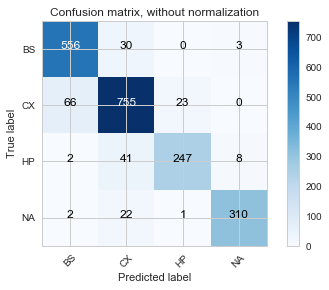

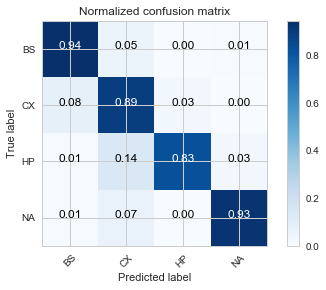

In [186]:
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = sgbm.classes_

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [187]:
genes_by_importances = pd.DataFrame({'gene': Level1_features.values.ravel(), 'importance': sgbm.feature_importances_})
genes_by_importances.sort_values(by='importance', ascending=False, inplace=True)

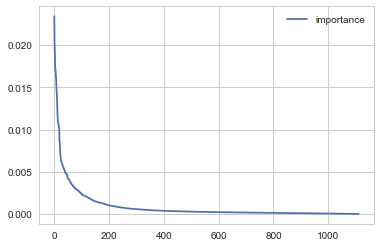

In [188]:
genes_by_importances.plot(use_index=False)
plt.show()

In [190]:
genes_by_importances.head(15)

,gene,importance
719,Pip5k1a,0.023427
980,Tbx1,0.020148
596,Lrrc17,0.019355
1024,Ttr,0.017678
374,Gm14915,0.017130
442,Gm42418,0.016982
906,Sez6,0.016212
1077,mt-Atp8,0.015958
576,Kif15,0.014770
692,Olfr685,0.014285
